In [1]:
import os
import gc
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
import innvestigate
# This is required for innvestigate and must be called before models are loaded.
tf.compat.v1.disable_eager_execution()
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras.models import Model
from keras.layers import Dense,LeakyReLU, Dropout, Add, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import Callback
from matplotlib.colors import Normalize
from sklearn.preprocessing import FunctionTransformer
tf.keras.utils.set_random_seed(0)
tf.config.list_physical_devices('GPU')
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.engine.training_v1")
import xarray as xr
#import innvestigate
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.signal import butter, sosfilt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import innvestigate
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap # <-- Import for custom colormap


2025-08-20 13:57:05.982473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-20 13:57:06.103766: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-20 13:57:06.138756: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
In_name = "TS_anom" #
Out_name = "TOA_anom" #


#====================== Here is 1D data ===============================#
# Paths to the datasets
# file_hist = "E:\\Yue\\CESM2\\test\\test.CESM2-historical.ens-mean.ANN.1850-2014.new.nc"
# file_2xCO2 = "E:\\Yue\\test\\test.2xCO2.ANN.new.nc"
# file_4xCO2 = "E:\\Yue\\CESM2\\test\\test.CESM2-4xCO2.ANN.nc"

######### CESM1 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.historical.ens-mean.ANN.1920-2100.new.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.ANN.new.nc"
######### CESM1 #########
'''
######### CESM2 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-historical.ens-mean.ANN.1850-2014.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
######### CESM2 #########
'''
#====================== End of 1D data ================================#

#====================== here is 2D data ===============================#

#====================== End of 1D data ================================#

# === Load historical data ===
ds_hist = xr.open_dataset(file_hist)
print("Historical dataset loaded:", ds_hist)

Historical dataset loaded: <xarray.Dataset>
Dimensions:   (lon: 288, lat: 192, time: 181)
Coordinates:
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time      (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
Data variables:
    TS        (time, lat, lon) float32 ...
    TOA       (time) float64 ...
    TOA_anom  (time) float64 ...
    TS_anom   (time, lat, lon) float32 ...
Attributes:
    ERF:      ERF = F - F_ctrl; my old CAM5 forcing run at /glade/campaign/un...
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu.ipynb
    author:   Y. Dong, 03/23/2025


In [4]:
lat = ds_hist["lat"]
lon = ds_hist["lon"]

time_hist = ds_hist["time"] 

######### CESM2 #########
#time_hist = [date.year for date in time_hist.values] #for C2 data
######### CESM2 #########

######### CESM1 #########
time_hist = time_hist.values #for C1 data
######### CESM1 #########

TS_hist = ds_hist[In_name]
TOA_hist = ds_hist[Out_name].values

# === Load 2xCO2 data ===
# ds_2xCO2 = xr.open_dataset(file_2xCO2)
# print("2xCO2 dataset loaded:", ds_2xCO2)

# time_2xCO2 = ds_2xCO2["year"]
# TS_2xCO2 = ds_2xCO2[In_name]
# TOA_2xCO2 = ds_2xCO2[Out_name].values

# === Load 4xCO2 data ===
ds_4xCO2 = xr.open_dataset(file_4xCO2)
print("4xCO2 dataset loaded:", ds_4xCO2)


# time_4xCO2_coords = ds_4xCO2["year"]
# time_4xCO2 = time_4xCO2_coords.values

'''
######### CESM2 #########
time_4xCO2 = ds_4xCO2["time"] 
time_4xCO2 = [date.year for date in time_4xCO2.values] #for C2 data
######### CESM2 #########
'''
######### CESM1 #########
time_4xCO2 = ds_4xCO2["year"] 
time_4xCO2 = time_4xCO2.values #C1 data
######### CESM1 #########


TS_4xCO2 = ds_4xCO2[In_name]
TOA_4xCO2 = ds_4xCO2[Out_name].values

# Optional: Print shapes to verify
print("TS_hist shape:", TS_hist.shape)
# print("TS_2xCO2 shape:", TS_2xCO2.shape)
print("TS_4xCO2 shape:", TS_4xCO2.shape)

4xCO2 dataset loaded: <xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, year: 150)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year      (year) int64 1850 1851 1852 1853 1854 ... 1995 1996 1997 1998 1999
Data variables:
    TS        (year, lat, lon) float64 ...
    TOA       (year) float64 ...
    TOA_anom  (year) float64 ...
    TS_anom   (year, lat, lon) float64 ...
Attributes:
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu.ipynb
TS_hist shape: (181, 192, 288)
TS_4xCO2 shape: (150, 192, 288)


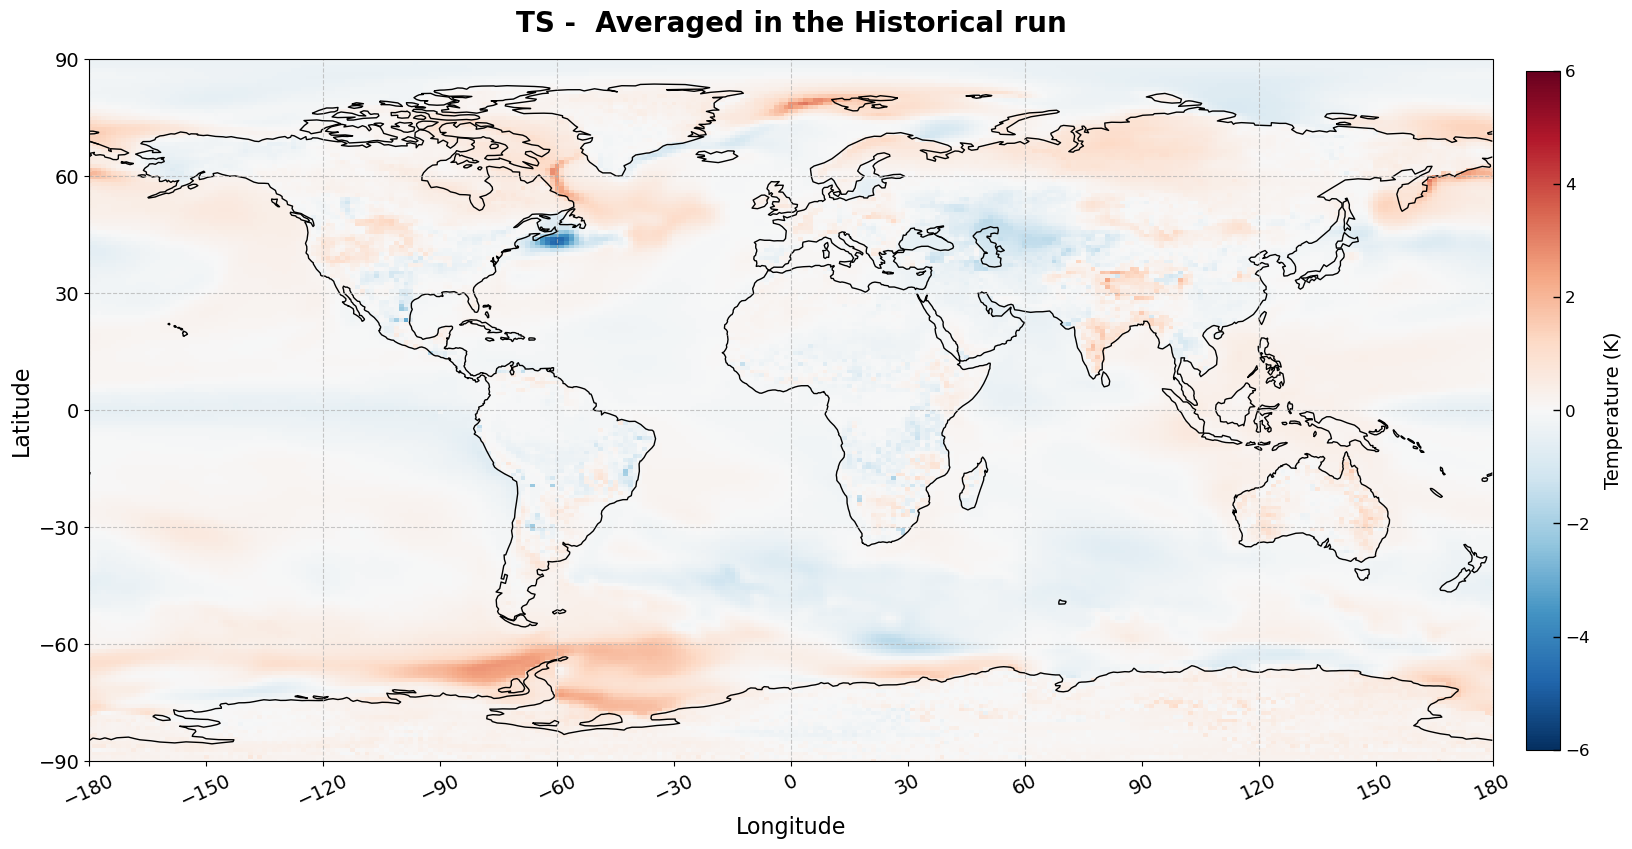

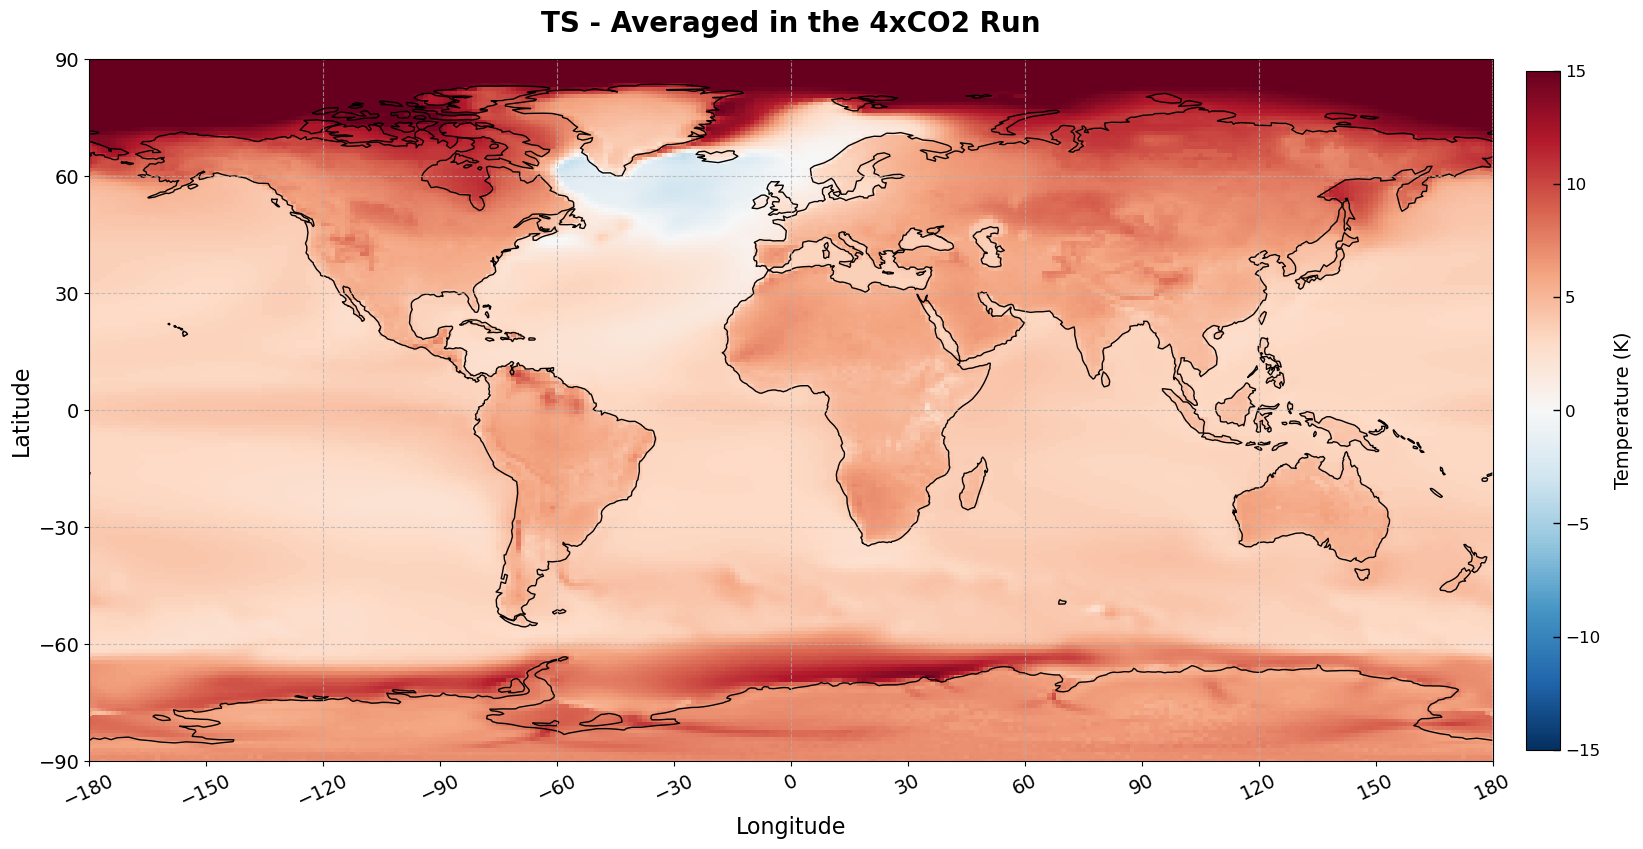

In [5]:
def plot_global_map(lon, lat, data2d, title, cbar_label="Temperature (K)", cmap="RdBu_r", vmin=None, vmax=None):
    """
    Plot a 2D global map using Cartopy with enhanced styling and colorbar.

    Parameters:
        lon (array): Longitudes
        lat (array): Latitudes
        data2d (2D array): Data to plot (must match lat/lon)
        title (str): Plot title
        cbar_label (str): Colorbar label
        cmap (str): Colormap
        vmin, vmax (float): Optional color scale limits
    """
    fig = plt.figure(figsize=(18, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the data
    pcm = ax.pcolormesh(lon, lat, data2d, cmap=cmap, transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)

    # Add colorbar
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.02, shrink=0.8)
    cbar.set_label(cbar_label, fontsize=14, labelpad=10)
    cbar.ax.tick_params(labelsize=12, direction='in', length=5, width=1)

    # Coastlines and grid
    ax.coastlines(resolution="110m", linewidth=1)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {"size": 13}
    gl.ylabel_style = {"size": 13}

    # Axis ticks
    ax.set_xticks(range(-180, 181, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.tick_params(axis="both", which="major", labelsize=14)
    plt.xticks(rotation=25, ha="center")

    # Title and labels
    ax.set_title(title, fontsize=20, fontweight="bold", pad=20)
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)

    plt.tight_layout()
    plt.show()





# Historical mean TS
plot_global_map(
    lon=lon,
    lat=lat,
    # data2d=np.mean(ds_hist[In_name], axis=0),
    data2d=ds_hist[In_name][0,:,:],
    title="TS -  Averaged in the Historical run",
    vmin=-6, vmax=6
)

# 2xCO2 mean TS
# plot_global_map(
#     lon=lon,
#     lat=lat,
#     data2d=np.mean(ds_2xCO2[In_name], axis=0),
#     title="TS - Averaged in the 2xCO2 Run",
#     vmin=-12, vmax=12
# )


# 4xCO2 mean TS
plot_global_map(
    lon=lon,
    lat=lat,
    data2d=np.mean(ds_4xCO2[In_name], axis=0),
    title="TS - Averaged in the 4xCO2 Run",
    vmin=-15, vmax=15
)



In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import ndimage # New import for spatial smoothing
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def calculate_trend_and_significance_temporal_smooth(relevance_data, time_axis, p_value_threshold=0.05, window_size=5):
    """
    Applies temporal smoothing (running mean) to relevance time series before
    calculating the linear trend and significance.
    'window_size' is the number of years for the running mean.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    num_time, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool)

    print(f"    Calculating trends with temporal smoothing (window={window_size}) for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            
            if np.all(np.isfinite(relevance_timeseries)):
                # Apply temporal smoothing using a rolling mean
                # Using pandas for convenient rolling mean with handling of edges
                series = pd.Series(relevance_timeseries)
                smoothed_timeseries = series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
                
                # Filter out NaNs that might be introduced by rolling mean if window is large
                valid_indices = ~np.isnan(smoothed_timeseries)
                
                if np.sum(valid_indices) > 1: # Need at least 2 points for regression
                    current_time_axis = time_axis[valid_indices]
                    current_data = smoothed_timeseries[valid_indices]
                    
                    if len(current_data) > 1: # Still need at least 2 points after NaN removal
                        lin_reg_result = stats.linregress(x=current_time_axis, y=current_data)
                        trend_map[y, x] = lin_reg_result.slope
                        if lin_reg_result.pvalue < p_value_threshold:
                            significance_mask[y, x] = True
    print("    Trend and significance calculation with temporal smoothing complete.")
    return trend_map, significance_mask

def calculate_trend_and_significance(relevance_data, time_axis, p_value_threshold=0.1):
    """
    Calculates the linear trend (slope) and a significance mask
    at each grid cell over time.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    _, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool) # Mask for significance

    print(f"    Calculating trends and significance for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            if np.all(np.isfinite(relevance_timeseries)) and len(relevance_timeseries) > 1:
                lin_reg_result = stats.linregress(x=time_axis, y=relevance_timeseries)
                trend_map[y, x] = lin_reg_result.slope
                if lin_reg_result.pvalue < p_value_threshold:
                    significance_mask[y, x] = True
    print("    Trend and significance calculation complete.")
    return trend_map, significance_mask

def apply_spatial_smoothing(data2d, sigma=1):
    """
    Applies a Gaussian filter to smooth a 2D map.
    Sigma is the standard deviation for Gaussian kernel.
    """
    print(f"    Applying spatial smoothing with sigma={sigma}...")
    smoothed_map = ndimage.gaussian_filter(data2d, sigma=sigma)
    print("    Smoothing complete.")
    return smoothed_map

In [7]:
ds_hist[In_name][0,:,:]

<xarray.DataArray 'TS_anom' (lat: 192, lon: 288)>
[55296 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
    time     int64 1920
Attributes:
    units:    K
    note:     TS_anom = TS_his - TS_ref
    ref:      B1850C5CN mean state

In [8]:
### load the mean and STD calculated in the Pre-industrial control run for normalization

# Paths to the datasets and trained model


########### CESM1 Model ##########
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom" #original model

#new model(1) -wrong one
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom" #wrong place but the model is for data 1

#corrected one model with best result so far
path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom"

#linear model C1
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_linear/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_linear+linear/TOA_anom/'

#change Gelu C1
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM1/Gelu_only/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+elu/TOA_anom'
#change PRelu C1
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM1/Prelu_only/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+PRelu/TOA_anom/'
######### CESM1 #########

########## CESM2 Model ######
#==================data1=================
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom"

#data1 model(1) gelu   Correct
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data1_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom"

#data 1 linear
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_linear(1)/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_linear+linear/TOA_anom"
#data 1 only changed Gelu
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/Gelu_data1)/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+elu/TOA_anom/'
#data 1 changed PRelu for 2nd layer
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/PRelu_data1/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+PRelu/TOA_anom/'

#===================data2================== 
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom"

#model gelu
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom" 


#data 2 linear
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_linear(2)/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_linear+linear/TOA_anom'
#data 2 only change Gelu for 1st layer
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom/'
#data 2 only change PRelu for 2nd layer
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/PRelu_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+PRelu/TOA_anom'

######### CESM2 #########

normalization= sio.loadmat(os.path.join(path_PIc, 'Normalization.mat'))

X_mean = normalization['X_mean']
X_std = normalization['X_std']
y_mean = normalization['y_mean']
y_std = normalization['y_std']


TS_hist_norm = (TS_hist-X_mean)/X_std.squeeze()
# TS_2xCO2_norm = (TS_2xCO2-X_mean)/X_std.squeeze()
TS_4xCO2_norm = (TS_4xCO2-X_mean)/X_std.squeeze()

TS_hist_norm = TS_hist_norm.values[..., tf.newaxis]
# TS_2xCO2_norm = TS_2xCO2_norm.values[..., tf.newaxis]
TS_4xCO2_norm = TS_4xCO2_norm.values[..., tf.newaxis]

print(X_mean)
print(X_std)

[[0]]
[[[0.53236276]
  [0.5272246 ]
  [0.52714384]
  ...
  [0.52715605]
  [0.5320779 ]
  [0.5270208 ]]

 [[0.5789423 ]
  [0.5785266 ]
  [0.5860141 ]
  ...
  [0.5794204 ]
  [0.58237875]
  [0.583376  ]]

 [[0.6280227 ]
  [0.61705714]
  [0.613267  ]
  ...
  [0.6247527 ]
  [0.6240835 ]
  [0.6179534 ]]

 ...

 [[1.0660722 ]
  [1.0682158 ]
  [1.0702783 ]
  ...
  [1.060526  ]
  [1.0623665 ]
  [1.06411   ]]

 [[1.0350558 ]
  [1.0358475 ]
  [1.0366569 ]
  ...
  [1.0323555 ]
  [1.033299  ]
  [1.0342044 ]]

 [[1.0114969 ]
  [1.0116085 ]
  [1.0117124 ]
  ...
  [1.0110848 ]
  [1.0112363 ]
  [1.0113714 ]]]


In [9]:
from tensorflow.keras import backend as K
# load the neural network trained from Pre-industrial control simulation

n_folds = 5
n_ensembles = 1

pred_hist_ALL = np.empty((TOA_hist.shape[0],0))
# pred_2xCO2_ALL = np.empty((TOA_2xCO2.shape[0],0))
pred_4xCO2_ALL = np.empty((TOA_4xCO2.shape[0],0))


for fold_no in range(1,n_folds+1):

    pred_hist = np.zeros((TOA_hist.shape[0],1));
    # pred_2xCO2 = np.zeros((TOA_2xCO2.shape[0],1));
    pred_4xCO2 = np.zeros((TOA_4xCO2.shape[0],1));
    for ens_no in range(1,n_ensembles+1):
        K.clear_session() # Clears the Keras session and TensorFlow graph
        gc.collect()  
        Model = load_model(os.path.join(path_PIc,'model_fold'+str(fold_no)+'_ens'+str(ens_no)+'.h5'))
        pred_hist = pred_hist+ Model.predict(TS_hist_norm, batch_size=4)
        # pred_2xCO2 = pred_2xCO2+ Model.predict(TS_2xCO2_norm)
        pred_4xCO2 = pred_4xCO2+ Model.predict(TS_4xCO2_norm)
        
    pred_hist = pred_hist/n_ensembles
    # pred_2xCO2 = pred_2xCO2/n_ensembles
    pred_4xCO2 = pred_4xCO2/n_ensembles


# re-scale the prediction from the neural network
    pred_hist = pred_hist*y_std + y_mean
    # pred_2xCO2 = pred_2xCO2*y_std + y_mean
    pred_4xCO2 = pred_4xCO2*y_std + y_mean



    pred_hist_ALL = np.concatenate(( pred_hist_ALL,pred_hist),axis = 1)
    # pred_2xCO2_ALL = np.concatenate(( pred_2xCO2_ALL,pred_2xCO2),axis = 1)
    pred_4xCO2_ALL = np.concatenate(( pred_4xCO2_ALL,pred_4xCO2),axis = 1)




2025-08-20 13:57:11.377524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-20 13:57:11.844404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2025-08-20 13:57:11.851017: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-08-20 13:57:12.712474: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2025-08-20 13:57:13.184074: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No suc

In [10]:
def plot_predictions(time, truth, preds, title):
    """
    Plots the ground truth, mean prediction, and individual model predictions with transparency.

    Parameters:
        time (array-like): Time axis values.
        truth (array-like): Ground truth values.
        preds (2D array): Predictions from ensemble or multiple models (shape: time x ensemble).
        title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot truth
    ax.plot(time, truth, label="Truth", color="C0", linewidth=2)

    # Plot mean prediction
    mean_pred = np.mean(preds, axis=1)
    ax.plot(time, mean_pred, label="Prediction (Mean)", color="C1", linewidth=1.8)

    # Plot individual models
    for i in range(preds.shape[1]):
        ax.plot(time, preds[:, i], linewidth=1, alpha=0.5,
                label="Prediction (CV" + str(i+1) + ")")

    # Style
    ax.set_xlabel("Time (Year)", fontsize=16)
    ax.set_ylabel(Out_name, fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_title(title, fontsize=18, pad=15)
    ax.legend(fontsize=14, loc="best")

    # R² annotation
    r2 = r2_score(truth, mean_pred)
    ax.text(0.02, 0.95, f"$R^2$ = {r2:.3f}", transform=ax.transAxes,
            fontsize=16, bbox=dict(facecolor="white", edgecolor="black", alpha=0.5))

    plt.tight_layout()
    plt.show()


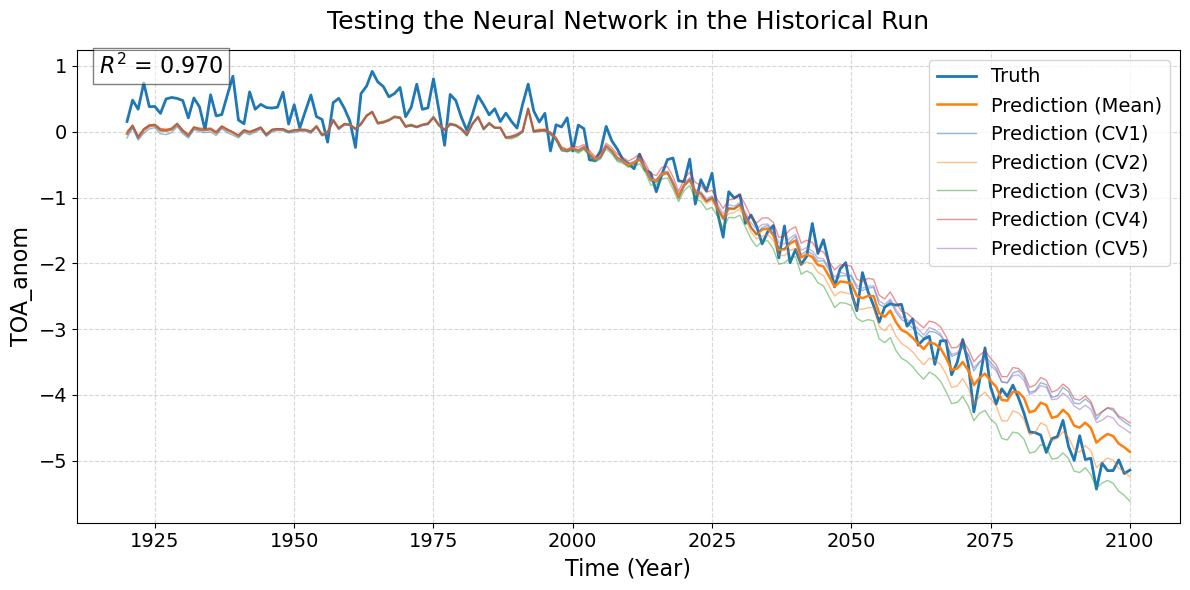

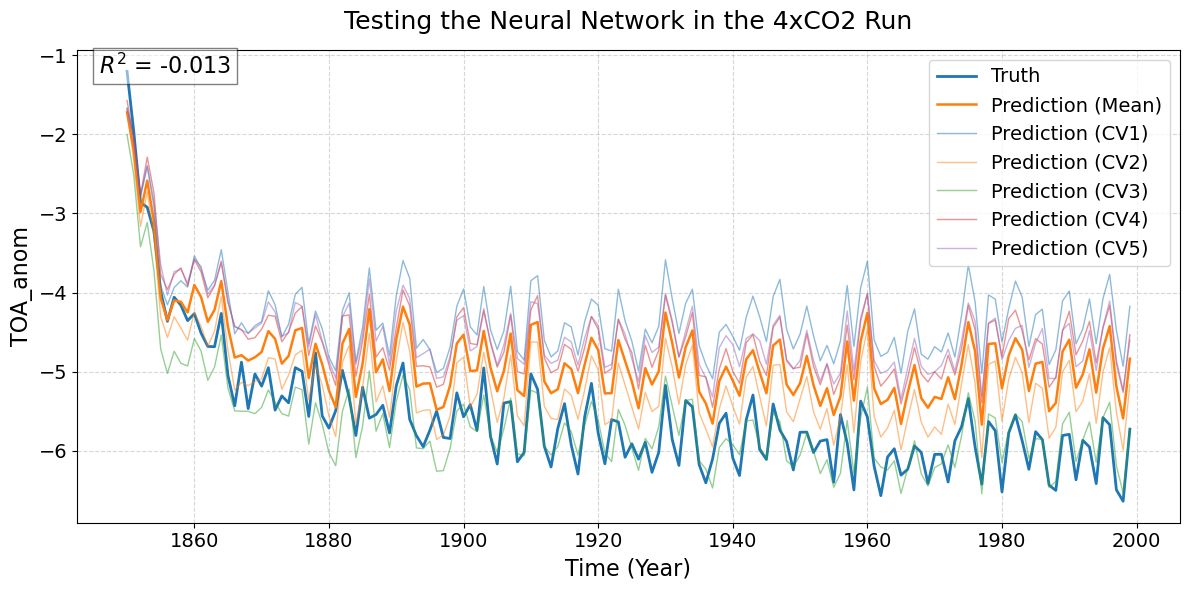

In [11]:
plot_predictions(time_hist, TOA_hist, pred_hist_ALL,
                 "Testing the Neural Network in the Historical Run")


#plot_predictions(time_2xCO2, TOA_2xCO2, pred_2xCO2_ALL,
#                  "Testing the Neural Network in the 2xCO2 Run")


plot_predictions(time_4xCO2, TOA_4xCO2, pred_4xCO2_ALL,
                 "Testing the Neural Network in the 4xCO2 Run")



▶️ PROCESSING LRP FOR SCENARIO: HISTORICAL
    Analyzing model: model_fold1_ens1.h5


2025-08-20 13:57:18.028275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5


2025-08-20 13:57:19.793808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5


2025-08-20 13:57:21.332482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5


2025-08-20 13:57:22.911160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5


2025-08-20 13:57:24.438296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


✅ Full attribution map saved to: attribution_map_historical.npy


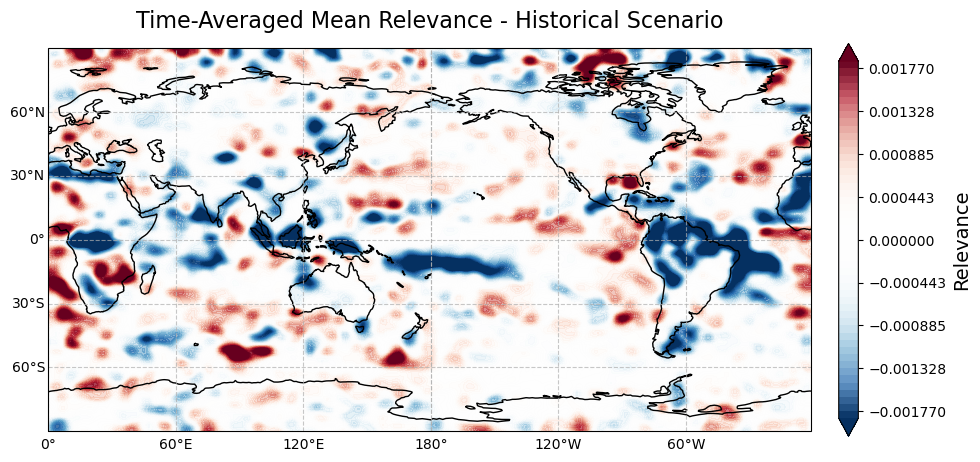


▶️ PROCESSING LRP FOR SCENARIO: 4XCO2
    Analyzing model: model_fold1_ens1.h5


2025-08-20 13:57:29.700640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5


2025-08-20 13:57:31.254186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5


2025-08-20 13:57:32.722421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5


2025-08-20 13:57:34.187154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5


2025-08-20 13:57:35.612432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


✅ Full attribution map saved to: attribution_map_4xCO2.npy


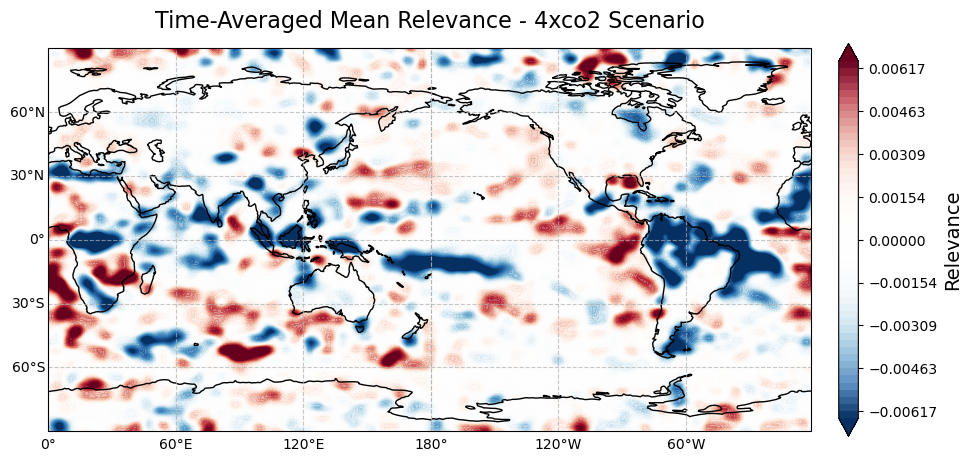


▶️ CALCULATING AND PLOTTING DIFFERENCE


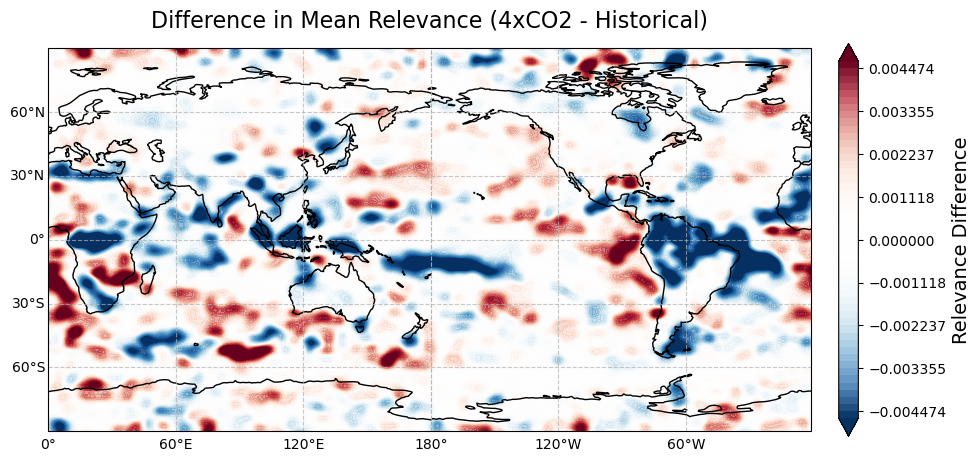

In [12]:
#original
from scipy.ndimage import gaussian_filter
'''
def plot_pacific_centered_map(lon, lat, data2d, title, cbar_label="Relevance"):
    """
    Plots a 2D global map using Cartopy, centered on the Pacific Ocean,
    with a tight, percentile-based color scale.
    """
    # Set color scale limit based on the 98th percentile to see patterns clearly
    vmax = np.nanpercentile(np.abs(data2d), 98)
    vmin = -vmax
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    pcm = ax.pcolormesh(lon, lat, data2d, cmap="RdBu_r", transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)
    
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()
'''
#first smoothing
'''
def plot_pacific_centered_map(lon, lat, data2d, title, cbar_label="Relevance", smoothing_sigma=1.5):
    """
    Plots a 2D global map using Cartopy, centered on the Pacific Ocean,
    with a smooth, interpolated appearance.

    Args:
        ...
        smoothing_sigma (float, optional): 
            The standard deviation for the Gaussian kernel to smooth the data.
            If None, no smoothing is applied. Defaults to 1.5.
    """
    # --- 1. SMOOTH THE DATA (OPTIONAL BUT RECOMMENDED) ---
    # The Gaussian filter reduces small-scale noise in the attribution map.
    if smoothing_sigma is not None and smoothing_sigma > 0:
        data2d_to_plot = gaussian_filter(data2d, sigma=smoothing_sigma)
    else:
        data2d_to_plot = data2d

    # --- 2. SET COLOR SCALE ---
    # Use the 98th percentile to prevent extreme outliers from washing out the colormap.
    vmax = np.nanpercentile(np.abs(data2d_to_plot), 98)
    vmin = -vmax
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    # --- 3. PLOT WITH GOURAUD SHADING FOR A SMOOTH LOOK ---
    # The key change is adding shading='gouraud'. This interpolates the
    pcm = ax.pcolormesh(lon, lat, data2d_to_plot, cmap="RdBu_r", 
                        transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax,
                        shading='gouraud') # <-- THIS IS THE KEY
    
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()
'''
'''
#this is making the "weak one" transparent
# ...

def plot_pacific_centered_map(lon, lat, data2d, title, cbar_label="Relevance", 
                            smoothing_sigma=1.5):
    """
    Plots a 2D global map, making weak values transparent to emphasize strong signals.

    Args:
        ...
        smoothing_sigma (float, optional): 
            Standard deviation for the Gaussian kernel to smooth the data.
    """
    # --- 1. SMOOTH THE DATA WITH CORRECT BOUNDARY CONDITIONS ---
    if smoothing_sigma is not None and smoothing_sigma > 0:
        data2d_to_plot = gaussian_filter(data2d, sigma=smoothing_sigma, mode=['nearest', 'wrap'])
    else:
        data2d_to_plot = data2d

    # --- 2. CREATE A CUSTOM COLORMAP WITH ALPHA BLENDING ---
    # This is the key to making weak values fade out smoothly.
    # We start with the base colormap.
    base_cmap = plt.get_cmap('RdBu_r')
    # Get the list of colors from the base map.
    colors = base_cmap(np.linspace(0, 1, 256))
    # Create an alpha channel that is 0 (transparent) at the center and 1 (opaque) at the extremes.
    # This creates a "V" shape, making the middle of the colormap transparent.
    alpha = np.abs(np.linspace(-1, 1, 256))
    # Set the alpha channel for our new colors.
    colors[:, -1] = alpha
    # Create the new colormap from our modified list of colors.
    alpha_cmap = LinearSegmentedColormap.from_list("alpha_cmap", colors)

    # --- 3. SET COLOR SCALE ---
    # Use the 98th percentile to prevent extreme outliers from washing out the colormap.
    vmax = np.nanpercentile(np.abs(data2d_to_plot), 99) 
    vmin = -vmax
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    # --- 4. PLOT WITH THE NEW CUSTOM COLORMAP ---
    pcm = ax.pcolormesh(lon, lat, data2d_to_plot, cmap=alpha_cmap, # <-- Use the new map
                        transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax,
                        shading='gouraud')
    
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()
'''
'''
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import gc
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import innvestigate
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap # <-- Import for custom colormap

def plot_pacific_centered_map(lon, lat, data2d, title, cbar_label="Relevance", 
                            smoothing_sigma=1.5):
    """
    Plots a 2D global map, making weak values transparent to emphasize strong signals.

    Args:
        ...
        smoothing_sigma (float, optional): 
            Standard deviation for the Gaussian kernel to smooth the data.
    """
    # --- 1. SMOOTH THE DATA WITH CORRECT BOUNDARY CONDITIONS ---
    if smoothing_sigma is not None and smoothing_sigma > 0:
        data2d_to_plot = gaussian_filter(data2d, sigma=smoothing_sigma, mode=['nearest', 'wrap'])
    else:
        data2d_to_plot = data2d

    # --- 2. CREATE A CUSTOM COLORMAP WITH ALPHA BLENDING ---
    # This is the key to making weak values fade out smoothly.
    # We start with the base colormap.
    base_cmap = plt.get_cmap('RdBu_r')
    # Get the list of colors from the base map.
    colors = base_cmap(np.linspace(0, 1, 256))
    
    # Create a steeper alpha channel to make weak values more transparent.
    # By raising the linear alpha to a power (e.g., 2 or 3), we increase the contrast.
    # A higher power makes the transition from transparent to opaque much sharper.
    alpha = np.abs(np.linspace(-1, 1, 256))**1.5 
    
    # Set the alpha channel for our new colors.
    colors[:, -1] = alpha
    # Create the new colormap from our modified list of colors.
    alpha_cmap = LinearSegmentedColormap.from_list("alpha_cmap", colors)

    # --- 3. SET COLOR SCALE ---
    # Use the 98th percentile to prevent extreme outliers from washing out the colormap.
    vmax = np.nanpercentile(np.abs(data2d_to_plot), 96) 
    vmin = -vmax
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    # --- 4. PLOT WITH THE NEW CUSTOM COLORMAP ---
    pcm = ax.pcolormesh(lon, lat, data2d_to_plot, cmap=alpha_cmap, # <-- Use the new map
                        transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax,
                        shading='gouraud')
    
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()
'''
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import gc
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import innvestigate
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap

def plot_pacific_centered_map(lon, lat, data2d, title, cbar_label="Relevance", 
                            smoothing_sigma=1.5):
    """
    Plots a 2D global map using a filled contour plot (contourf) for a 
    naturally smooth appearance.

    Args:
        ...
        smoothing_sigma (float, optional): 
            Standard deviation for the Gaussian kernel to smooth the data.
    """
    # --- 1. SMOOTH THE DATA WITH CORRECT BOUNDARY CONDITIONS ---
    if smoothing_sigma is not None and smoothing_sigma > 0:
        data2d_to_plot = gaussian_filter(data2d, sigma=smoothing_sigma, mode=['nearest', 'wrap'])
    else:
        data2d_to_plot = data2d

    # --- 2. CREATE A CUSTOM COLORMAP WITH ALPHA BLENDING ---
    base_cmap = plt.get_cmap('RdBu_r')
    colors = base_cmap(np.linspace(0, 1, 256))
    # Using a gentler exponent for a smoother fade-out
    alpha = np.abs(np.linspace(-1, 1, 256))**1.5 
    colors[:, -1] = alpha
    alpha_cmap = LinearSegmentedColormap.from_list("alpha_cmap", colors)

    # --- 3. SET COLOR SCALE AND CONTOUR LEVELS ---
    vmax = np.nanpercentile(np.abs(data2d_to_plot), 96) 
    vmin = -vmax
    
    # Define the number of contour levels. More levels = smoother plot.
    # 50 is a good starting point.
    levels = np.linspace(vmin, vmax, 51)
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    # --- 4. PLOT USING CONTOURF ---
    # We now use contourf instead of pcolormesh.
    # It requires the 'levels' argument to know how many color steps to draw.
    pcm = ax.contourf(lon, lat, data2d_to_plot, cmap=alpha_cmap, 
                      levels=levels, # <-- Key argument for contourf
                      extend='both', # Extends the colorbar with arrows
                      transform=ccrs.PlateCarree())
    
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()
    
def ensemble_lrp_analyze(model_dir, num_folds, data_to_analyze):
    """
    Loads each model in an ensemble, generates its LRP map, and returns
    the averaged map from all models.
    """
    all_relevance_maps = []
    for i in range(1, num_folds + 1):
        K.clear_session(); gc.collect()
        model_path = os.path.join(model_dir, f'model_fold{i}_ens1.h5')
        print(f"    Analyzing model: {os.path.basename(model_path)}")
        try:
            model = load_model(model_path)
            # The analyzer needs the model without the final activation if it's not linear
            analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
            relevance = analyzer.analyze(data_to_analyze)
            all_relevance_maps.append(relevance)
        except Exception as e:
            print(f"      ❌ ERROR analyzing model {i}: {e}")
            continue
    
    if not all_relevance_maps:
        return None
        
    # Stack along a new axis and compute the mean across the folds
    ensemble_relevance = np.mean(np.stack(all_relevance_maps), axis=0)
    return ensemble_relevance

# --- 4. Main LRP Analysis and Plotting ---
TEST_SCENARIOS = {
    "historical": TS_hist_norm,
    "4xCO2": TS_4xCO2_norm
}
mean_relevance_maps = {}

for scenario, data in TEST_SCENARIOS.items():
    print(f"\n======================================================")
    print(f"▶️ PROCESSING LRP FOR SCENARIO: {scenario.upper()}")
    print(f"======================================================")
    
    # Generate the full [time, lat, lon] attribution map
    attribution_map = ensemble_lrp_analyze(
        model_dir=path_PIc,
        num_folds=n_folds,
        data_to_analyze=data
    )
    
    if attribution_map is not None:
        # Squeeze out the channel dimension for saving and plotting
        attribution_map = attribution_map.squeeze()

        mean_relevance_map = np.mean(attribution_map, axis=0)
        mean_relevance_maps[scenario] = mean_relevance_map
        
        # Save the full attribution map for future analyses
        output_filename = f"attribution_map_{scenario}.npy"
        np.save(output_filename, attribution_map)
        print(f"✅ Full attribution map saved to: {output_filename}")
        
        # Calculate the time-averaged mean relevance
        mean_relevance_map = np.mean(attribution_map, axis=0)
        
        # Plot the mean relevance map
        plot_pacific_centered_map(
            lon, lat, mean_relevance_map,
            title=f"Time-Averaged Mean Relevance - {scenario.capitalize()} Scenario"
        )

try:
    if "historical" in mean_relevance_maps and "4xCO2" in mean_relevance_maps:
        print("\n======================================================")
        print("▶️ CALCULATING AND PLOTTING DIFFERENCE")
        print("======================================================")
        
        # Calculate the difference (4xCO2 - historical)
        difference_map = mean_relevance_maps["4xCO2"] - mean_relevance_maps["historical"]
        
        # Plot the difference map
        plot_pacific_centered_map(
            lon, lat, difference_map,
            title="Difference in Mean Relevance (4xCO2 - Historical)",
            cbar_label="Relevance Difference",
            smoothing_sigma=1.5
        )
    else:
        # This case handles if the loop ran but one of the scenarios was missing
        print("\n⚠️ Could not calculate difference: One or both scenarios not found in results.")
except NameError:
    print("\n❌ Error: 'mean_relevance_maps' dictionary not found.")
    print("   This can happen if the analysis loop was not run before this step.")
    print("   Please ensure all previous code cells have been executed successfully.")

        

In [13]:
# ==========================================================
# NEW TASKS (from PI Meeting)
# ==========================================================
print("\nStarting new analysis tasks...")

# --- 1. UPDATED Pacific-Centered Plotting Function (No Land Coloring) ---
def plot_pacific_centered_map_no_land(lon, lat, data2d, title, cbar_label=""):
    """
    Plots a 2D global map centered on the Pacific Ocean, without coloring land separately.
    """
    vmax = np.nanpercentile(np.abs(data2d), 100)
    vmin = -vmax
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    pcm = ax.pcolormesh(lon, lat, data2d, cmap="RdBu_r", transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)
    
    # Only add coastlines for reference, do not fill land with color
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False
    
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()

print("Using data already in memory...")

lrp_hist = TS_hist_norm
lrp_4xco2 = TS_4xCO2_norm
# ==========================================================
# Task 1: Difference in Lambda Contribution (4xCO2 minus Historical)
# ==========================================================
print("\n--- Task 1: Calculating Difference in Lambda Contributions (4xCO2 - Historical) ---")
try:
    # We need the physically scaled local lambda maps from the previous step.
    # Let's recalculate them here to be self-contained.
    
    # Historical Map (1980-2014)
    time_hist_np_task1 = np.array(time_hist)
    start_idx_task1 = np.where(time_hist_np_task1 == 1980)[0][0]
    end_idx_task1 = np.where(time_hist_np_task1 == 2014)[0][0] + 1
    lrp_hist_sliced_task1 = lrp_hist[start_idx_task1:end_idx_task1, :, :]
    ts_mean_hist_sliced_task1 = ts_mean_hist[start_idx_task1:end_idx_task1]
    local_lambda_physical_hist_map = calculate_local_lambda_map(
        lrp_hist_sliced_task1 * y_std[0,0],
        ts_mean_hist_sliced_task1
    )
    
    # 4xCO2 Map (Full Period)
    local_lambda_physical_4xco2_map = calculate_local_lambda_map(
        lrp_4xco2 * y_std[0,0],
        ts_mean_4xco2
    )
    
    # Calculate the difference
    lambda_contribution_difference = local_lambda_physical_4xco2_map - local_lambda_physical_hist_map
    
    # Plot the difference map using the new plotting function
    plot_pacific_centered_map_no_land(lon, lat, lambda_contribution_difference,
                                      title="Difference in Local λ Contribution (4xCO2 minus Historical)",
                                      cbar_label="Difference in Local λ (W/m²/K per global K)")

except Exception as e:
    print(f"An unexpected ERROR occurred during Task 1: {e}")

# ==========================================================
# Task 2: "Fast" vs. "Slow" Lambda in 4xCO2 Scenario
# ==========================================================
print("\n--- Task 2: Analyzing 'Fast' vs. 'Slow' Lambda in 4xCO2 Scenario ---")
try:
    time_4xCO2_np_task2 = np.array(time_4xCO2)
    
    # --- Split data into fast (first 20 yrs) and slow (rest) periods ---
    fast_period_lrp = lrp_4xco2[:20, :, :]
    fast_period_ts_mean = ts_mean_4xco2[:20]
    fast_period_toa_pred = np.mean(pred_4xCO2_ALL[:20, :], axis=1)

    slow_period_lrp = lrp_4xco2[20:, :, :]
    slow_period_ts_mean = ts_mean_4xco2[20:]
    slow_period_toa_pred = np.mean(pred_4xCO2_ALL[20:, :], axis=1)

    # --- Calculate and Plot Fast vs. Slow Global Lambdas ---
    fast_lambda_reg = stats.linregress(x=fast_period_ts_mean, y=fast_period_toa_pred)
    slow_lambda_reg = stats.linregress(x=slow_period_ts_mean, y=slow_period_toa_pred)
    
    print(f"    Calculated Fast Lambda (Years 1-20): {fast_lambda_reg.slope:.3f} W/m²/K")
    print(f"    Calculated Slow Lambda (Years 21-150): {slow_lambda_reg.slope:.3f} W/m²/K")

    # Create the scatter plot with two regression lines
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(fast_period_ts_mean, fast_period_toa_pred, alpha=0.6, label="Fast Response (Yrs 1-20)", color='C0')
    ax.scatter(slow_period_ts_mean, slow_period_toa_pred, alpha=0.6, label="Slow Response (Yrs 21-150)", color='C3')
    
    # Plot regression lines
    line_x_fast = np.array([np.min(fast_period_ts_mean), np.max(fast_period_ts_mean)])
    ax.plot(line_x_fast, fast_lambda_reg.slope * line_x_fast + fast_lambda_reg.intercept, color='blue', linestyle='--', label=f"Fast λ = {fast_lambda_reg.slope:.3f}")
    
    line_x_slow = np.array([np.min(slow_period_ts_mean), np.max(slow_period_ts_mean)])
    ax.plot(line_x_slow, slow_lambda_reg.slope * line_x_slow + slow_lambda_reg.intercept, color='red', linestyle='--', label=f"Slow λ = {slow_lambda_reg.slope:.3f}")

    ax.set_xlabel("Area-Weighted Global Mean TS Anomaly (K)", fontsize=14)
    ax.set_ylabel("Global Mean Predicted TOA Anomaly (W/m²)", fontsize=14)
    ax.set_title("Fast vs. Slow Climate Feedback (λ) in 4xCO2", fontsize=16)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # --- Calculate and Plot Fast vs. Slow Local Lambda Contribution Maps ---
    # Calculate fast contribution map
    fast_contrib_map = calculate_local_lambda_map(fast_period_lrp * y_std[0,0], fast_period_ts_mean)
    plot_pacific_centered_map_no_land(lon, lat, fast_contrib_map,
                                      title="Local λ Contribution - 4xCO2 Fast Response (Years 1-20)",
                                      cbar_label="Local λ Contribution (W/m²/K per global K)")

    # Calculate slow contribution map
    slow_contrib_map = calculate_local_lambda_map(slow_period_lrp * y_std[0,0], slow_period_ts_mean)
    plot_pacific_centered_map_no_land(lon, lat, slow_contrib_map,
                                      title="Local λ Contribution - 4xCO2 Slow Response (Years 21-150)",
                                      cbar_label="Local λ Contribution (W/m²/K per global K)")
    
    # Calculate and plot the difference map (slow - fast)
    slow_fast_difference_map = slow_contrib_map - fast_contrib_map
    plot_pacific_centered_map_no_land(lon, lat, slow_fast_difference_map,
                                      title="Difference in Local λ Contribution (Slow minus Fast)",
                                      cbar_label="Difference in Local λ (W/m²/K per global K)")
except Exception as e:
    print(f"An unexpected ERROR occurred during Task 2: {e}")


Starting new analysis tasks...
Using data already in memory...

--- Task 1: Calculating Difference in Lambda Contributions (4xCO2 - Historical) ---
An unexpected ERROR occurred during Task 1: name 'ts_mean_hist' is not defined

--- Task 2: Analyzing 'Fast' vs. 'Slow' Lambda in 4xCO2 Scenario ---
An unexpected ERROR occurred during Task 2: name 'ts_mean_4xco2' is not defined
